# Minería de texto: proceso de examinar grandes colecciones de texto con el objetivo de generar nueva información

## Para ello la minería de datos utiliza principalmente el Procesamiento de Lenguaje Natural NLP.

### Vamos  analizar las publicaciones que han hecho en Twitter diferentes personalidades con el objetivo de conocer quién ha creado el texto.

In [1]:
"""
Instalar en Anaconda el paquete:
nltk       Natural Language toolkit
"""

'\nInstalar en Anaconda el paquete:\nnltk       Natural Language toolkit\n'

In [72]:
from matplotlib import style
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer   # stemmer = Despedazador
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer   # Relevancia sobre cada palabra en un documento
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV   # Para la validación cruzada
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import nltk   # Toolkit de herramientas de Lenguaje Natural
import numpy as np
import pandas as pd
import re   # Expresiones Regulares
import seaborn as sb
import string
import unidecode    # Quit string ascent punctuation
import warnings

warnings.filterwarnings( "ignore" )

# Required
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\44151139V\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\44151139V\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
"""
RE
https://aukera.es/blog/imagenes/cheat-sheet-expresiones-regulares-aukera-ga-gtm.pdf
https://cheatography.com/davechild/cheat-sheets/regular-expressions/
"""

'\nRE\nhttps://aukera.es/blog/imagenes/cheat-sheet-expresiones-regulares-aukera-ga-gtm.pdf\nhttps://cheatography.com/davechild/cheat-sheets/regular-expressions/\n'

In [4]:
tweets_elon = pd.read_csv( "./data/tweets/datos_tweets_@elonmusk.csv" )
tweets_edlee = pd.read_csv( "./data/tweets/datos_tweets_@mayoredlee.csv" )
tweets_bgates = pd.read_csv( "./data/tweets/datos_tweets_@BillGates.csv" )

In [5]:
tweets_elon.shape

(2678, 35)

In [6]:
tweets_edlee.shape

(2447, 35)

In [7]:
tweets_bgates.shape

(2087, 35)

In [8]:
tweets_elon.head(2)

screen_name   user_id            created_at     status_id  \
0    elonmusk  44196397  2017-11-09T17:28:57Z  9.286758e+17   
1    elonmusk  44196397  2017-11-09T17:12:46Z  9.286717e+17   

                                                text  retweet_count  \
0  "If one day, my words are against science, cho...          49919   
1  I placed the flowers\r\n\r\nThree broken ribs\...           5940   

   favorite_count  is_quote_status  quote_status_id  is_retweet  ...  \
0          104722            False              NaN       False  ...   
1           33725            False              NaN       False  ...   

   hashtags  coordinates  place_id place_type place_name place_full_name  \
0       NaN          NaN       NaN        NaN        NaN             NaN   
1       NaN          NaN       NaN        NaN        NaN             NaN   

   country_code country bounding_box_coordinates  bounding_box_type  
0           NaN     NaN                      NaN                NaN  
1           NaN     NaN                      NaN                NaN  

[2 rows x 35 columns]

In [9]:
# Juntamos todos en un sólo dataframe
tweets = pd.concat( [tweets_elon, tweets_edlee, tweets_bgates], ignore_index = True )

In [10]:
tweets.head(2)

screen_name   user_id            created_at     status_id  \
0    elonmusk  44196397  2017-11-09T17:28:57Z  9.286758e+17   
1    elonmusk  44196397  2017-11-09T17:12:46Z  9.286717e+17   

                                                text  retweet_count  \
0  "If one day, my words are against science, cho...          49919   
1  I placed the flowers\r\n\r\nThree broken ribs\...           5940   

   favorite_count  is_quote_status  quote_status_id  is_retweet  ...  \
0          104722            False              NaN       False  ...   
1           33725            False              NaN       False  ...   

   hashtags  coordinates  place_id place_type place_name place_full_name  \
0       NaN          NaN       NaN        NaN        NaN             NaN   
1       NaN          NaN       NaN        NaN        NaN             NaN   

   country_code country bounding_box_coordinates  bounding_box_type  
0           NaN     NaN                      NaN                NaN  
1           NaN     NaN                      NaN                NaN  

[2 rows x 35 columns]

In [11]:
tweets.shape

(7212, 35)

In [12]:
# Seleccionar y renombrar las columnas de interés
tweets = tweets[ ["screen_name", "created_at", "status_id", "text"] ]
tweets.columns = ["autor", "fecha", "id", "texto"]
tweets.head(2)

autor                 fecha            id  \
0  elonmusk  2017-11-09T17:28:57Z  9.286758e+17   
1  elonmusk  2017-11-09T17:12:46Z  9.286717e+17   

                                               texto  
0  "If one day, my words are against science, cho...  
1  I placed the flowers\r\n\r\nThree broken ribs\...

In [13]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7212 entries, 0 to 7211
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   autor   7212 non-null   object 
 1   fecha   7212 non-null   object 
 2   id      7212 non-null   float64
 3   texto   7212 non-null   object 
dtypes: float64(1), object(3)
memory usage: 225.5+ KB


In [14]:
tweets.dtypes

autor     object
fecha     object
id       float64
texto     object
dtype: object

In [15]:
for c in tweets.columns:
    print( "Columna '" + c + "': \t" + str( type( tweets[ c ][0] ) ) )

Columna 'autor': 	<class 'str'>
Columna 'fecha': 	<class 'str'>
Columna 'id': 	<class 'numpy.float64'>
Columna 'texto': 	<class 'str'>


In [16]:
# Queremos trabajar con fechas
tweets['fecha'] = pd.to_datetime( tweets['fecha'] )
tweets.dtypes

autor                 object
fecha    datetime64[ns, UTC]
id                   float64
texto                 object
dtype: object

In [17]:
tweets.head(2)

autor                     fecha            id  \
0  elonmusk 2017-11-09 17:28:57+00:00  9.286758e+17   
1  elonmusk 2017-11-09 17:12:46+00:00  9.286717e+17   

                                               texto  
0  "If one day, my words are against science, cho...  
1  I placed the flowers\r\n\r\nThree broken ribs\...

In [18]:
for c in tweets.columns:
    print( "Columna '" + c + "': \t" + str( type( tweets[ c ][0] ) ) )

Columna 'autor': 	<class 'str'>
Columna 'fecha': 	<class 'pandas._libs.tslibs.timestamps.Timestamp'>
Columna 'id': 	<class 'numpy.float64'>
Columna 'texto': 	<class 'str'>


In [19]:
# Para la gráfica temporal del nº de tweets de cada usuario (para no pisar los datos)
df_tiempo = tweets.copy()
df_tiempo.head(2)

autor                     fecha            id  \
0  elonmusk 2017-11-09 17:28:57+00:00  9.286758e+17   
1  elonmusk 2017-11-09 17:12:46+00:00  9.286717e+17   

                                               texto  
0  "If one day, my words are against science, cho...  
1  I placed the flowers\r\n\r\nThree broken ribs\...

In [20]:
# "Agrupar" por meses (quitamos el día)
df_tiempo["fecha"] = pd.to_datetime( df_tiempo["fecha"].dt.strftime( "%Y-%m" ) )
df_tiempo.head(2)

autor      fecha            id  \
0  elonmusk 2017-11-01  9.286758e+17   
1  elonmusk 2017-11-01  9.286717e+17   

                                               texto  
0  "If one day, my words are against science, cho...  
1  I placed the flowers\r\n\r\nThree broken ribs\...

In [21]:
# Agrupar los datos por mes.
# size nos da el nº de elementos/filas de cada grupo
df_tiempo2 = df_tiempo.groupby( df_tiempo["fecha"] ).size()
df_tiempo2

fecha
2011-09-01      1
2011-10-01     15
2011-11-01     15
2011-12-01      3
2012-01-01     32
             ... 
2017-07-01    277
2017-08-01    297
2017-09-01    209
2017-10-01    252
2017-11-01     54
Length: 75, dtype: int64

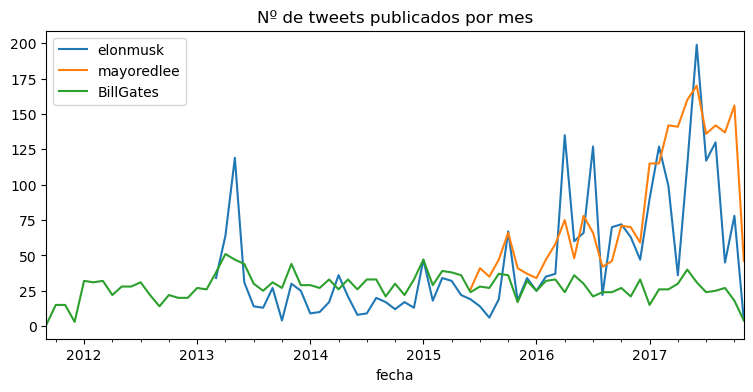

In [22]:
fig, ax = plt.subplots( figsize = (9, 4) )

for autor in tweets.autor.unique():
    df_temp = tweets[ tweets["autor"] == autor ].copy()
    df_temp["fecha"] = pd.to_datetime( df_temp["fecha"].dt.strftime( "%Y-%m" ) )
    df_temp = df_temp.groupby( df_temp["fecha"] ).size()  # agrupar por meses
    df_temp.plot( label = autor, ax = ax )

ax.set_title( "Nº de tweets publicados por mes" )
ax.legend()

In [23]:
# NOTA: Tweeter sólo permite bajar una cantidad de tweets...

In [24]:
"""
Text Mining:
Limpieza: eliminar del texto todo aquello que no aporte información sobre su temática, estructura o contenido
Ejemplo: urls, signos de puntuación, etiquetas HTML, caracteres sueltos y nºs

Tokenización: dividir el texto en las unidades que lo conforman (el elemento más sencillo con significado propio), para el análisis en cuestión, en este caso palabras.

Vamos a crear una función de limpieza y tokenización.
"""

'\nText Mining:\nLimpieza: eliminar del texto todo aquello que no aporte información sobre su temática, estructura o contenido\nEjemplo: urls, signos de puntuación, etiquetas HTML, caracteres sueltos y nºs\n\nTokenización: dividir el texto en las unidades que lo conforman (el elemento más sencillo con significado propio), para el análisis en cuestión, en este caso palabras.\n\nVamos a crear una función de limpieza y tokenización.\n'

In [25]:
print( string.punctuation )

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [26]:
def limpiar_tokenizar( texto ):
    # Texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminar urls
    nuevo_texto = re.sub( "http\S+", ' ', nuevo_texto )
    # Eliminar signos de puntuación. Nota: escapar la "'" al utilizar ''
    # '…' es un caracter especial para las frases largas
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\`\\{\\|\\}\\~\\…]'
    nuevo_texto = re.sub( regex, ' ', nuevo_texto )
    # Eliminar nºs
    nuevo_texto = re.sub( "\d+", ' ', nuevo_texto )
    # Eliminar espacios en blanco múltiples
    nuevo_texto = re.sub( "\\s+", ' ', nuevo_texto )
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split( sep = ' ' )
    # Eliminar tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    
    return( nuevo_texto )

In [27]:
df_tiempo["texto"][1]

'I placed the flowers\r\n\r\nThree broken ribs\r\nA pierced lung\r\nAnd still he fought\r\nFor peace at… https://t.co/MeEKf2ZntM'

In [28]:
limpiar_tokenizar( df_tiempo["texto"][1] )

['placed',
 'the',
 'flowers',
 'three',
 'broken',
 'ribs',
 'pierced',
 'lung',
 'and',
 'still',
 'he',
 'fought',
 'for',
 'peace',
 'at']

In [29]:
# english, spanish
idiom = "english"
stop_words = set( stopwords.words( idiom ) )
# Use English stemmer (despedazador)
stemmer = SnowballStemmer( idiom )
# https://www.nltk.org/howto/stem.html

def clean_tokenize( text ):
    # Remove ascents: ó -> o, Ó -> O, and to lower
    text = unidecode.unidecode( text ).lower()
    # Eliminar urls
    text = re.sub( "http\S+", ' ', text )
    # Remove punctuation and numbers
    text = re.sub( '[^a-z]', ' ', text )
    # Remove extra spaces in between
    text = re.sub( ' +', ' ', text )
    #print(text)
    # Remove stopwords and get the stem
    res = ' '.join( stemmer.stem( part ) for part in text.split() if part not in stop_words )
    return res.split()

def clean_tokenize_2( text ):
    # Remove ascents: ó -> o, Ó -> O, and to lower
    text = unidecode.unidecode( text ).lower()
    # Eliminar urls
    text = re.sub( "http\S+", ' ', text )
    # tokenize
    tokenizer = nltk.tokenize.RegexpTokenizer( r'[a-z]+' )
    return tokenizer.tokenize( text )

In [30]:
clean_tokenize( df_tiempo["texto"][1] + " 323 Camión cÓmer" )

['place',
 'flower',
 'three',
 'broken',
 'rib',
 'pierc',
 'lung',
 'still',
 'fought',
 'peac',
 'camion',
 'comer']

In [31]:
clean_tokenize_2( df_tiempo["texto"][1] + " 323 Camión cÓmer" )

['i',
 'placed',
 'the',
 'flowers',
 'three',
 'broken',
 'ribs',
 'a',
 'pierced',
 'lung',
 'and',
 'still',
 'he',
 'fought',
 'for',
 'peace',
 'at',
 'camion',
 'comer']

In [32]:
# Creamos una nueva columna con el texto tokenizado
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
tweets["texto_tokenizado"] = tweets["texto"].apply( lambda x: limpiar_tokenizar( x ) )

In [33]:
tweets[ ["texto", "texto_tokenizado"] ].head(3)

texto  \
0  "If one day, my words are against science, cho...   
1  I placed the flowers\r\n\r\nThree broken ribs\...   
2          Atatürk Anıtkabir https://t.co/al3wt0njr6   

                                    texto_tokenizado  
0  [if, one, day, my, words, are, against, scienc...  
1  [placed, the, flowers, three, broken, ribs, pi...  
2                               [atatürk, anıtkabir]

# Tidy data: hay que expandir cada lista de tokens
#### Hacer una fila por cada palabra
# Expansion/Unnest

## Necesario para facilitar la agrupación, contaje, gráficos, etc.

In [34]:
# Hacer una fila por cada palabra
tweets_tidy = tweets.explode( column = "texto_tokenizado" )
tweets_tidy

autor                     fecha            id  \
0      elonmusk 2017-11-09 17:28:57+00:00  9.286758e+17   
0      elonmusk 2017-11-09 17:28:57+00:00  9.286758e+17   
0      elonmusk 2017-11-09 17:28:57+00:00  9.286758e+17   
0      elonmusk 2017-11-09 17:28:57+00:00  9.286758e+17   
0      elonmusk 2017-11-09 17:28:57+00:00  9.286758e+17   
...         ...                       ...           ...   
7211  BillGates 2011-09-29 21:11:15+00:00  1.195196e+17   
7211  BillGates 2011-09-29 21:11:15+00:00  1.195196e+17   
7211  BillGates 2011-09-29 21:11:15+00:00  1.195196e+17   
7211  BillGates 2011-09-29 21:11:15+00:00  1.195196e+17   
7211  BillGates 2011-09-29 21:11:15+00:00  1.195196e+17   

                                                  texto texto_tokenizado  
0     "If one day, my words are against science, cho...               if  
0     "If one day, my words are against science, cho...              one  
0     "If one day, my words are against science, cho...              day  
0     "If one day, my words are against science, cho...               my  
0     "If one day, my words are against science, cho...            words  
...                                                 ...              ...  
7211  Nigeria has made phenomenal progress toward er...          efforts  
7211  Nigeria has made phenomenal progress toward er...               to  
7211  Nigeria has made phenomenal progress toward er...           finish  
7211  Nigeria has made phenomenal progress toward er...              the  
7211  Nigeria has made phenomenal progress toward er...              job  

[106540 rows x 5 columns]

# Luego hay que eliminar la columna 'texto'

In [35]:
tweets_tidy = tweets_tidy.drop( columns = "texto" )
tweets_tidy = tweets_tidy.rename( columns = { "texto_tokenizado": "token" } )
tweets_tidy.head(3)

autor                     fecha            id token
0  elonmusk 2017-11-09 17:28:57+00:00  9.286758e+17    if
0  elonmusk 2017-11-09 17:28:57+00:00  9.286758e+17   one
0  elonmusk 2017-11-09 17:28:57+00:00  9.286758e+17   day

In [36]:
# Palabras totales por autor
tweets_tidy.groupby( "autor" )["token"].count()

autor
BillGates     31447
elonmusk      33383
mayoredlee    41701
Name: token, dtype: int64

In [37]:
# Palabras totales diferentes por autor
tweets_tidy.groupby( by = "autor" )["token"].nunique()

autor
BillGates     4762
elonmusk      6502
mayoredlee    5519
Name: token, dtype: int64

In [38]:
# Longitud media de los tweets
# Cada 'id' es 1 tweet
temp_df = pd.DataFrame( tweets_tidy.groupby( by = ["autor", "id"] )["token"].count() )
temp_df.head(2)

token
autor     id                 
BillGates 1.195196e+17     17
          1.213001e+17     16

In [39]:
tweets_tidy.groupby( by = ["autor", "id"] )["token"].count()

autor       id          
BillGates   1.195196e+17    17
            1.213001e+17    16
            1.217459e+17    21
            1.217460e+17    22
            1.267828e+17    15
                            ..
mayoredlee  9.284318e+17    23
            9.286985e+17    17
            9.286987e+17    17
            9.287057e+17    20
            9.287568e+17    22
Name: token, Length: 7184, dtype: int64

In [40]:
# Funciones de agregación
temp_df.groupby( "autor" )["token"].agg( ["mean", "std"] )

mean       std
autor                          
BillGates   15.118750  3.347996
elonmusk    12.526454  6.932601
mayoredlee  17.097581  3.462371

# Ejercicio: obtener y mostrar en forma de tabla las 5 palabras más utilizadas por cada autor

In [41]:
# https://pandas.pydata.org/docs/reference/groupby.html
# "reset_index" añade nombre a la nueva columna obtenida por el count()
# https://stackoverflow.com/questions/29836477/pandas-create-new-column-with-count-from-groupby
# https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html

tweets_tidy.groupby( by = ["autor", "token"] )["token"].count().reset_index( name = "count" )\
.groupby( "autor" ).apply( lambda x: x.sort_values( "count", ascending = False ).head(5) )

autor token  count
autor                                    
BillGates  4130    BillGates   the   1180
           4204    BillGates    to   1115
           2886    BillGates    of    670
           2054    BillGates    in    590
           2172    BillGates    is    453
elonmusk   10506    elonmusk   the    985
           10619    elonmusk    to    916
           8700     elonmusk    of    638
           7668     elonmusk    is    543
           7526     elonmusk    in    477
mayoredlee 16219  mayoredlee    to   1693
           16144  mayoredlee   the   1355
           11447  mayoredlee   amp   1212
           14581  mayoredlee   our   1104
           15551  mayoredlee    sf    873

### Vemos que los términos más frecuentes son artículos, preposiciones, etc. Palabras que no aportan nada relevante sobre el texto.
### Son las stopwords

# Eliminar 1º las stopwords

In [63]:
# Ver arriba:
#nltk.download('stopwords')
idiom = "english"
stop_words = list( stopwords.words( idiom ) )
# Se añade la stopword: emp, ex
stop_words.extend( ("amp", "ex") )

In [64]:
print( stop_words )

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [65]:
print( stop_words[60:80] )

['a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into']


In [66]:
tweets_tidy.head(3)

autor                     fecha            id token
0  elonmusk 2017-11-09 17:28:57+00:00  9.286758e+17    if
0  elonmusk 2017-11-09 17:28:57+00:00  9.286758e+17   one
0  elonmusk 2017-11-09 17:28:57+00:00  9.286758e+17   day

In [67]:
# Quit the stopwords: nos quedaremos con las que no están en las stop_words
tweets_tidy_no_sw = tweets_tidy[ ~(tweets_tidy["token"].isin( stop_words )) ]
tweets_tidy_no_sw.head(3)

autor                     fecha            id  token
0  elonmusk 2017-11-09 17:28:57+00:00  9.286758e+17    one
0  elonmusk 2017-11-09 17:28:57+00:00  9.286758e+17    day
0  elonmusk 2017-11-09 17:28:57+00:00  9.286758e+17  words

In [68]:
# Ahora que hemos eliminado las stopwords vamos a ver las palabras top 10 por autor
df_temp1 = tweets_tidy_no_sw[ tweets_tidy_no_sw.autor == "BillGates"]
h10 = df_temp1["token"].head(10)

In [69]:
h10

5125     tanzania
5125        hopes
5125    eliminate
5125          one
5125      world’s
5125      painful
5125     diseases
5125          saw
5125      village
5125          i’m
Name: token, dtype: object

In [58]:
# El id es del mismo tweet

In [70]:
# Top 10
counts1 = df_temp1["token"].value_counts( ascending = False ).head(10)
counts1

great     216
one       146
world     143
people    140
new       120
help      113
polio     102
lives     101
energy     96
via        92
Name: token, dtype: int64

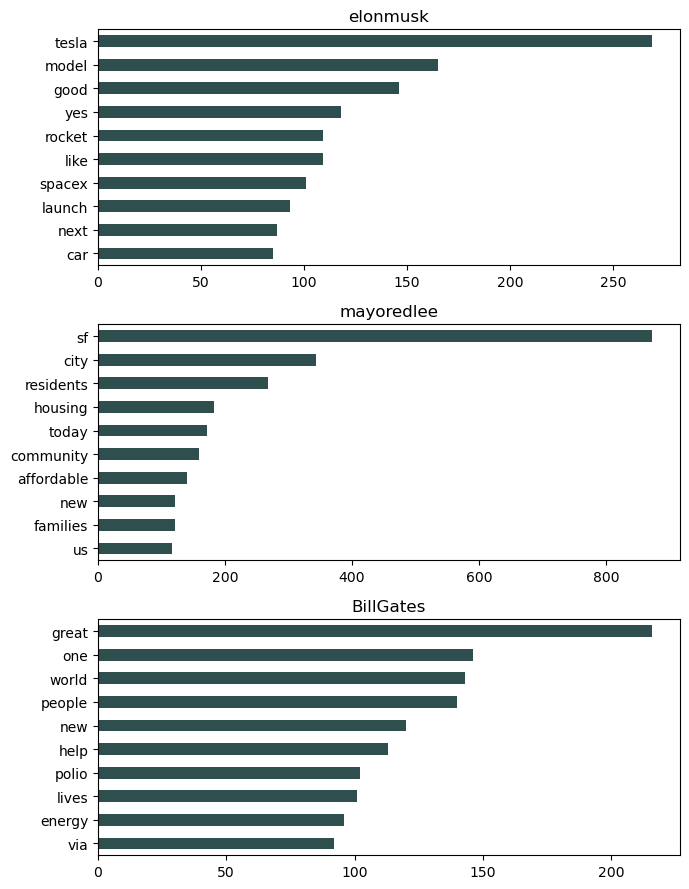

In [71]:
# Ver las palabras top 10 por autor
fig, axs = plt.subplots( nrows = 3, ncols = 1, figsize = (7, 9) )
for i, autor in enumerate( tweets_tidy_no_sw.autor.unique() ):
    df_temp = tweets_tidy_no_sw[ tweets_tidy_no_sw.autor == autor ]
    counts = df_temp["token"].value_counts( ascending = False ).head(10)
    counts.plot( kind = "barh", color = "darkslategray", ax = axs[i] )
    axs[i].invert_yaxis()
    axs[i].set_title( autor )

fig.tight_layout()

# sf = San Francisco

# Term Frequency (tf) - Inverse Document Frequency (idf)
### Puede haber palabras más comunes que aparezcan muchas veces sin aportar información relevante.
### >>> Utilizar idf
### i.e. cuanto más veces aparezca una palabra MENOS importancia, y cuanto menos MÁS importante.
## Se medirá con respecto a cuánto aparece en otros tweets

### Utilizar la Clase TfidfVectorizer de Scikit Learn

# >>>
### Para poder aplicar algoritmos de clasificación a un texto, aplicar representación numérica: Bag of Words
### Se crea un set de los tokens de todos los tweets, asignando un valor a cada dimensión (token).
### En la mayoría de los casos, el valor utilizado es el tf-idf.

In [73]:
# Crearemos un modelo de SVM
# Cada columna será un token, cada fila es un tweet, y el valor de inserción al tf-idf.
datos_X = tweets.loc[ tweets.autor.isin( ["elonmusk", "mayoredlee"] ), "texto" ]
datos_y = tweets.loc[ tweets.autor.isin( ["elonmusk", "mayoredlee"] ), "autor" ]

In [74]:
X_train, X_test, y_train, y_test = train_test_split( datos_X, datos_y, test_size = 0.2, random_state = 224 )

In [75]:
# Vectorización tf-idf
# Creación de la matriz tf-idf
# min_df = mínimo nº de documentos en los que debe de aparecer un término para NO ser excluido en el tokenizado
# Este filtrado es una forma de eliminar ruido del modelo
vectorizador_ifidf = TfidfVectorizer( min_df = 3, stop_words = stop_words )
# fit: learn vocabulary and idf from training set
vectorizador_ifidf.fit( X_train )

TfidfVectorizer(min_df=3,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])